# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Вам нужно научиться определять рыночную стоимость объектов недвижимости. Для этого проведите исследовательский анализ данных и установите параметры, влияющие на цену объектов. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта и других объектов — эти данные автоматически получены из геосервисов. Количество парков и водоёмов также заполняется без участия пользователя.

**Цель работы**: найти параметры, которые больше всего влияют на цену квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет.

**План работы**: 
1. Изучить общую информацию о данных.
2. Выполнить предобработку данных
3. Добавить в таблицу новые параметры.
4. Провести исследовательский анализ данных.


## Загрузка данных и изучение общей информации

In [1]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

import warnings

warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('/datasets/real_estate_data.csv', delimiter='\\t', engine='python')

In [3]:
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

array([[<AxesSubplot:title={'center':'total_images'}>,
        <AxesSubplot:title={'center':'last_price'}>,
        <AxesSubplot:title={'center':'total_area'}>,
        <AxesSubplot:title={'center':'rooms'}>],
       [<AxesSubplot:title={'center':'ceiling_height'}>,
        <AxesSubplot:title={'center':'floors_total'}>,
        <AxesSubplot:title={'center':'living_area'}>,
        <AxesSubplot:title={'center':'floor'}>],
       [<AxesSubplot:title={'center':'kitchen_area'}>,
        <AxesSubplot:title={'center':'balcony'}>,
        <AxesSubplot:title={'center':'airports_nearest'}>,
        <AxesSubplot:title={'center':'cityCenters_nearest'}>],
       [<AxesSubplot:title={'center':'parks_around3000'}>,
        <AxesSubplot:title={'center':'parks_nearest'}>,
        <AxesSubplot:title={'center':'ponds_around3000'}>,
        <AxesSubplot:title={'center':'ponds_nearest'}>],
       [<AxesSubplot:title={'center':'days_exposition'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], d

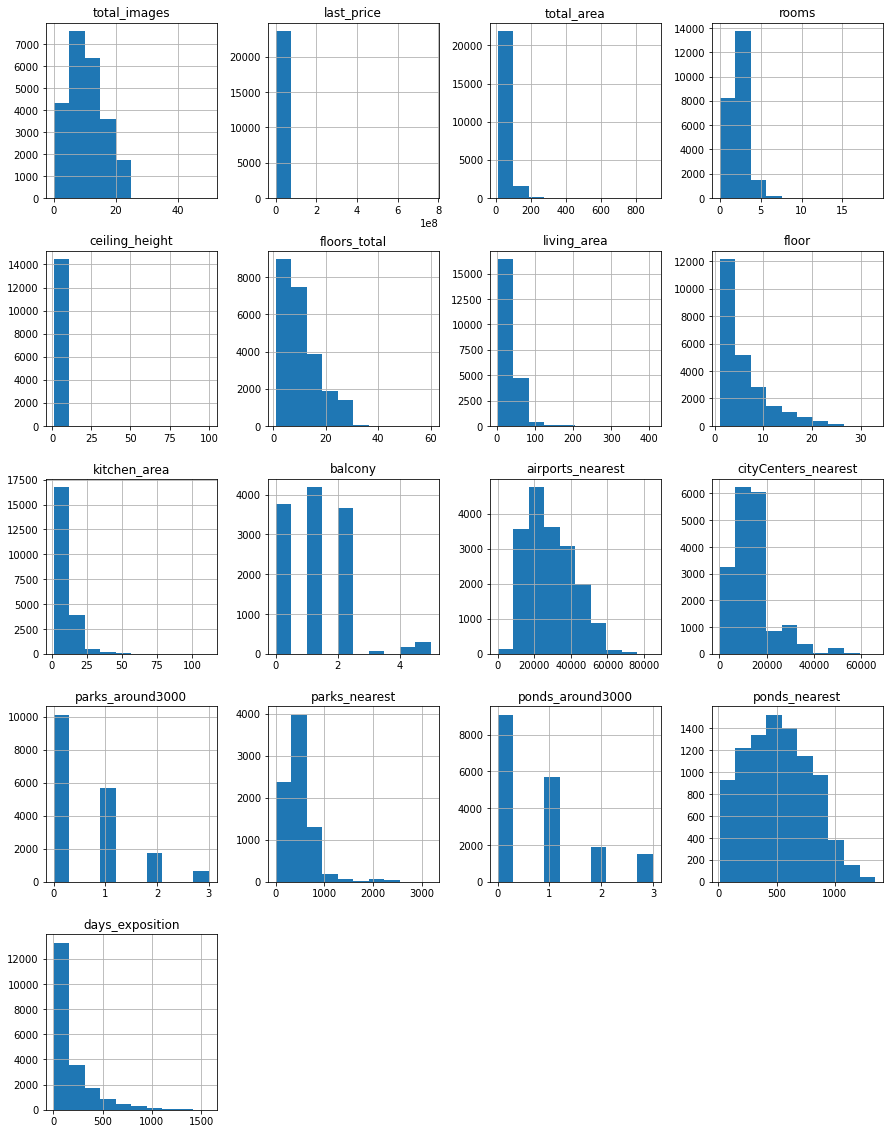

In [5]:
df.hist(figsize=(15, 20))

В большинстве столбцов данные не соответствуют распределению Пуассона. А значит, в них есть значения, которые могут помешать исследованию

In [6]:
df.duplicated().sum()

0

**Обзор данных**:
- в некоторых параметрах слишком много пропущенных значений, что может препятствовать исследовательскому анализу данных,
- параметры *first_day_exposition* и *is_apartment* имеют некорректный тип данных, также в целях аналитики следует изменить тип данных для столбцов *open_plan* и *studio*,
- в столбцах *ceiling_height*, *floors_total*, *last_price*, *living_area* присутствуют аномальные значения,
- явные дубликаты в данных не замечены.

## Предобработка данных

### Поиск и изучение пропущенных значений в столбцах

In [7]:
df.isna().mean().sort_values(ascending=False)*100

is_apartment            88.290645
parks_nearest           65.909954
ponds_nearest           61.559559
balcony                 48.605426
ceiling_height          38.799105
airports_nearest        23.384953
cityCenters_nearest     23.287902
ponds_around3000        23.283683
parks_around3000        23.283683
days_exposition         13.422507
kitchen_area             9.612220
living_area              8.029875
floors_total             0.362885
locality_name            0.206760
total_images             0.000000
last_price               0.000000
studio                   0.000000
floor                    0.000000
rooms                    0.000000
first_day_exposition     0.000000
total_area               0.000000
open_plan                0.000000
dtype: float64

В столбцах *is_apartment, balcony, park_nearest, ponds_nearest, ceiling_height* слишком много пропусков. Такие пустые столбцы можно было бы удалить, однако их данные могут сильно влиять на итоговую цену.
Проверим, как они коррелируют с ценой с помощью heatmap.

<AxesSubplot:>

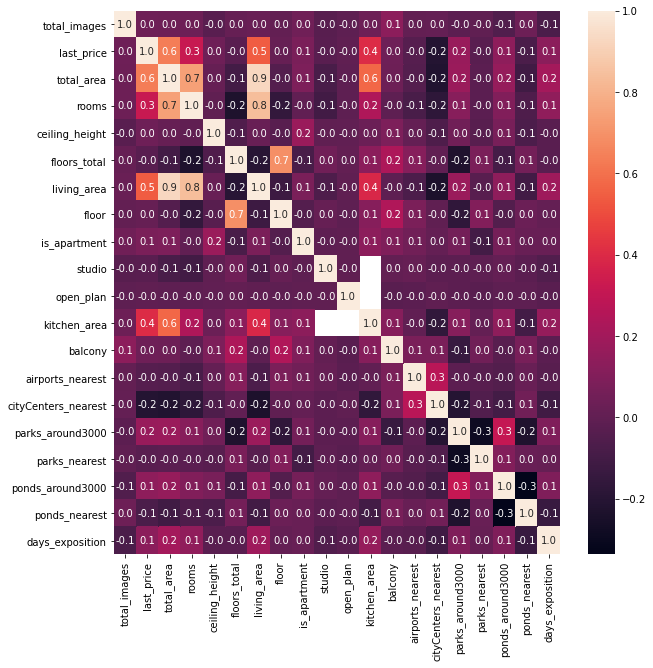

In [8]:
df2 = df.copy()
df2.dropna(subset=['is_apartment'], inplace=True)
df2['is_apartment'] = df2['is_apartment'].astype(int)  

plt.figure(figsize=(10, 10))
sns.heatmap(df2.corr(), annot=True, fmt=".1f")

На графике видно, что данные из столбцов *is_apartment, balcony, park_nearest, ponds_nearest* слабо влияют на цену, а также плохо взаимосвязаны с другими значениями, значит от них можно смело избавляться.
В то же время пропусков в *floors_total, locality_name* довольно мало, так что строки с пропусками в этих столбцах просто удалим.

In [9]:
df3 = df.drop(columns=['is_apartment', 'balcony', 'parks_nearest', 'ponds_nearest'])
df3.dropna(subset=['floors_total', 'locality_name'], inplace=True)

Оставшиеся столбцы с пропусками зависят от значений в других столбцах, так что пропущенные данные можно восстановить, оценивая другие значения в наборе с помощью класса *IterativeImputer*

In [10]:
numeric_cols = [cname for cname in df3.columns if df3[cname].dtype in ['int64', 'float64']]

In [11]:
imputer = IterativeImputer()
df4 = df3[numeric_cols]
imputer.fit(df4)
df5 = pd.DataFrame(imputer.transform(df4), columns=numeric_cols)

In [12]:
df6 = df3.copy()
df6[numeric_cols] = df5[numeric_cols]
df6.dropna(inplace=True)

In [13]:
df6.isna().sum()

total_images            0
last_price              0
total_area              0
first_day_exposition    0
rooms                   0
ceiling_height          0
floors_total            0
living_area             0
floor                   0
studio                  0
open_plan               0
kitchen_area            0
locality_name           0
airports_nearest        0
cityCenters_nearest     0
parks_around3000        0
ponds_around3000        0
days_exposition         0
dtype: int64

В результате, мы получаем таблицу без пропусков

Причинами пропусков в данных являются технические ошибки(так, в некоторых поселениях вообще нет прудов, парков и аэропортов) и челевеческий фактор(люди могли просто не указать количество балконов и высоту потолка)

### Изменение типов данных в столбцах

In [14]:
df6.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,studio,open_plan,kitchen_area,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,ponds_around3000,days_exposition
0,20.0,13000000.0,108.0,2019-03-07T00:00:00,3.0,2.700000,16.0,51.000000,8.0,False,False,25.000000,Санкт-Петербург,18863.0,16028.0,1.0,2.0,226.805513
1,7.0,3350000.0,40.4,2018-12-04T00:00:00,1.0,2.633656,11.0,18.600000,1.0,False,False,11.000000,посёлок Шушары,12817.0,18603.0,0.0,0.0,81.000000
2,10.0,5196000.0,56.0,2015-08-20T00:00:00,2.0,2.864729,5.0,34.300000,4.0,False,False,8.300000,Санкт-Петербург,21741.0,13933.0,1.0,2.0,558.000000
3,0.0,64900000.0,159.0,2015-07-24T00:00:00,3.0,3.422242,14.0,92.959048,9.0,False,False,23.296302,Санкт-Петербург,28098.0,6800.0,2.0,3.0,424.000000
4,2.0,10000000.0,100.0,2018-06-19T00:00:00,2.0,3.030000,14.0,32.000000,13.0,False,False,41.000000,Санкт-Петербург,31856.0,8098.0,2.0,1.0,121.000000


In [15]:
df6.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23433 entries, 0 to 23564
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23433 non-null  float64
 1   last_price            23433 non-null  float64
 2   total_area            23433 non-null  float64
 3   first_day_exposition  23433 non-null  object 
 4   rooms                 23433 non-null  float64
 5   ceiling_height        23433 non-null  float64
 6   floors_total          23433 non-null  float64
 7   living_area           23433 non-null  float64
 8   floor                 23433 non-null  float64
 9   studio                23433 non-null  bool   
 10  open_plan             23433 non-null  bool   
 11  kitchen_area          23433 non-null  float64
 12  locality_name         23433 non-null  object 
 13  airports_nearest      23433 non-null  float64
 14  cityCenters_nearest   23433 non-null  float64
 15  parks_around3000   

Тип данных временного столбца *first_day_exposition* нет datetime, а столбцы *studio и open_plan* имеют тип bool, c которым трудно взаимодействать в процессе анализа, так что заменим его на int, где 1 - True, 0 - False

In [16]:
df6['first_day_exposition'] = pd.to_datetime(df6['first_day_exposition'], format="%Y-%m-%dT%H:%M:%S")

In [17]:
df6['studio'] = df6['studio'].astype(int)
df6['open_plan'] = df6['open_plan'].astype(int)

In [18]:
from sklearn.preprocessing import OrdinalEncoder

df7 = df6.copy()
ordinal_encoder = OrdinalEncoder()
df7['locality_id'] = ordinal_encoder.fit_transform(df7[['locality_name']])

### Поиск неявных дубликатов

Единственный оставшийся столбец с категориальными переменными - *locality_name*. Изучим его уникальные значения

В процессе поиска дубликатов были найдены два вида неявных дубликатов:

- написание "е" вместо "ё" в названии поселений,
- разное написание административных обозначений поселений

In [19]:
df7 = df6.copy()

In [20]:
df7['locality_name'] = (
    df7['locality_name']
    .str.replace('ё', 'е')
    .str.lower()
    .replace(['поселок городского типа ', 'городской поселок ', 'деревня ', 'село ', 'поселок станции ', 'городской поселок ', 'садовое товарищество ', 'садоводческое некоммерческое товарищество ', 'поселок при железнодорожной станции ', 'коттеджный поселок ', 'поселок городской '],
             'поселок ', regex=True)
) 

**В результате предобработки данных были:**

- заменены некторые пропущенные значения в столбцах,
- удалены столбцы, в которых было слишком много пропусков,
- изменены типы данных столбцов *first_day_exposition, open_plan и studio*,
- удалены неявные дубликаты

## Добавление в таблицу новых столбцов

In [21]:
df7.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,studio,open_plan,kitchen_area,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,ponds_around3000,days_exposition
0,20.0,13000000.0,108.0,2019-03-07,3.0,2.700000,16.0,51.000000,8.0,0,0,25.000000,санкт-петербург,18863.0,16028.0,1.0,2.0,226.805513
1,7.0,3350000.0,40.4,2018-12-04,1.0,2.633656,11.0,18.600000,1.0,0,0,11.000000,поселок шушары,12817.0,18603.0,0.0,0.0,81.000000
2,10.0,5196000.0,56.0,2015-08-20,2.0,2.864729,5.0,34.300000,4.0,0,0,8.300000,санкт-петербург,21741.0,13933.0,1.0,2.0,558.000000
3,0.0,64900000.0,159.0,2015-07-24,3.0,3.422242,14.0,92.959048,9.0,0,0,23.296302,санкт-петербург,28098.0,6800.0,2.0,3.0,424.000000
4,2.0,10000000.0,100.0,2018-06-19,2.0,3.030000,14.0,32.000000,13.0,0,0,41.000000,санкт-петербург,31856.0,8098.0,2.0,1.0,121.000000


Добавим в таблицу столбы:
- средняя цена за квадратный метр *price_per_meter*
- день выпуска заявления *exposion_weekday*
- месяц выпуска заявления *exposion_month*
- год выпуска заявления *exposition_year*
- тип этажа квартиры("первый", "последний", "другой") *floor_category*
- расстояние до центра населённого пункта в километрах *cityCenters_nearest_km*

In [22]:
df7['price_per_meter'] = df7['last_price'] / df7['total_area']

In [23]:
df7['exposion_weekday'] = df7['first_day_exposition'].dt.dayofweek

In [24]:
df7['exposion_month'] = df7['first_day_exposition'].dt.month

In [25]:
df7['exposion_year'] = df7['first_day_exposition'].dt.year

In [26]:
def floor_cat(row):
    floor = row['floor']
    last_fl = row['floors_total']
    if floor == 1:
        return 'первый'
    elif floor == last_fl:
        return 'последний'
    return 'другой'

In [27]:
df7['floor_category'] = df7.apply(floor_cat, axis=1)

In [28]:
df7['cityCenters_nearest_km'] = round(df7['cityCenters_nearest'] / 1000)

In [29]:
good_data = df7.copy()

In [30]:
good_data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,studio,...,cityCenters_nearest,parks_around3000,ponds_around3000,days_exposition,price_per_meter,exposion_weekday,exposion_month,exposion_year,floor_category,cityCenters_nearest_km
0,20.0,13000000.0,108.0,2019-03-07,3.0,2.700000,16.0,51.000000,8.0,0,...,16028.0,1.0,2.0,226.805513,120370.370370,3,3,2019,другой,16.0
1,7.0,3350000.0,40.4,2018-12-04,1.0,2.633656,11.0,18.600000,1.0,0,...,18603.0,0.0,0.0,81.000000,82920.792079,1,12,2018,первый,19.0
2,10.0,5196000.0,56.0,2015-08-20,2.0,2.864729,5.0,34.300000,4.0,0,...,13933.0,1.0,2.0,558.000000,92785.714286,3,8,2015,другой,14.0
3,0.0,64900000.0,159.0,2015-07-24,3.0,3.422242,14.0,92.959048,9.0,0,...,6800.0,2.0,3.0,424.000000,408176.100629,4,7,2015,другой,7.0
4,2.0,10000000.0,100.0,2018-06-19,2.0,3.030000,14.0,32.000000,13.0,0,...,8098.0,2.0,1.0,121.000000,100000.000000,1,6,2018,другой,8.0


В таблицу были добавлены новые столбцы, которые понадобятся в процессе исследовательского анализа данных

## Исследовательский анализ данных

### Изучим некоторые параметры таблицы и построим их гистограммы

In [31]:
research_cols = ['total_area', 'living_area', 'kitchen_area',
                 'last_price', 'rooms', 'ceiling_height',
                 'floor_category', 'floors_total',
                 'cityCenters_nearest']

array([[<AxesSubplot:title={'center':'ceiling_height'}>]], dtype=object)

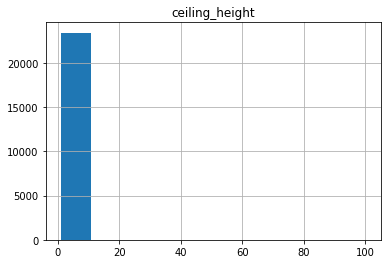

In [32]:
good_data.hist('ceiling_height')

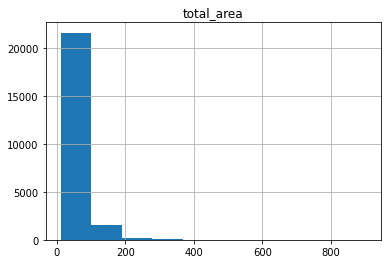

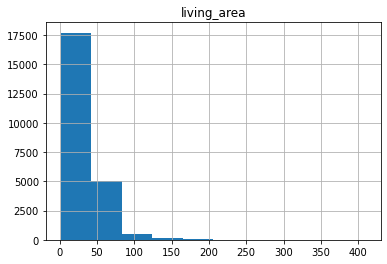

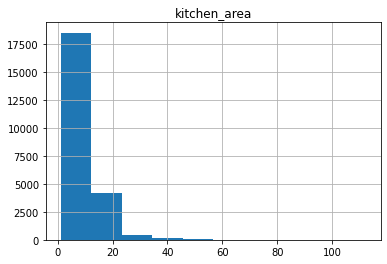

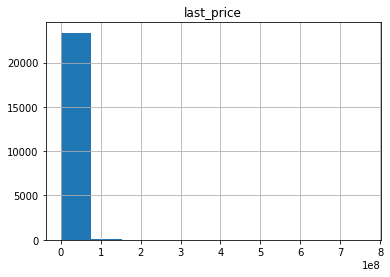

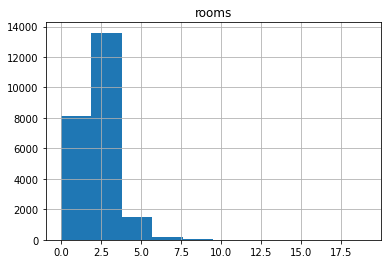

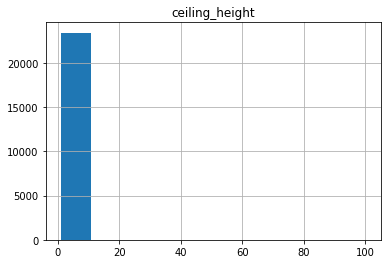

array([[<AxesSubplot:title={'center':'parks_nearest'}>]], dtype=object)

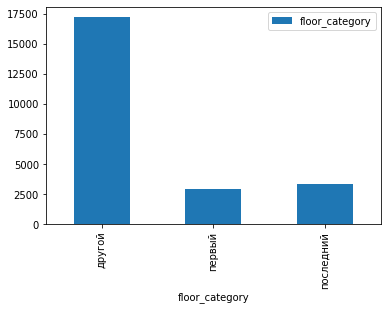

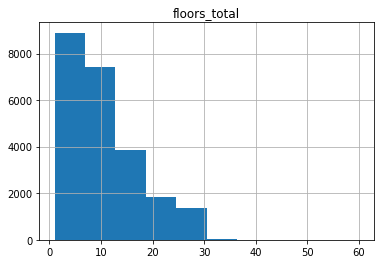

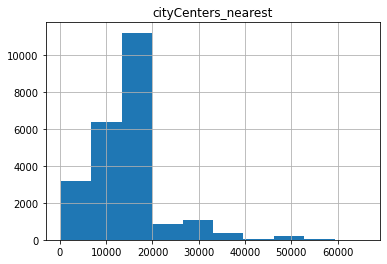

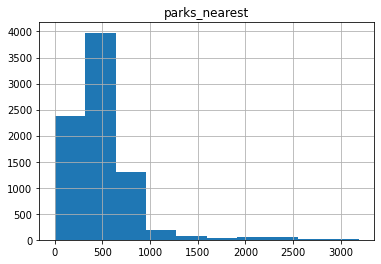

In [33]:
for col in research_cols:
    try:
        good_data.hist(col)
    except:
        plt.show()
        (
        good_data
        .groupby('floor_category')['floor_category']
        .count()
        .plot(kind='bar', legend=True)
        )
#Я удалил столбец parks_nearest, поэтому строю график по df
df.hist('parks_nearest')

В параметрах:
- total_area
- living_area
- kitchen_area
- last_price
- rooms

распределение данных соответсвует нормальному, однако в остальных столбцах присутвуют скачки данных 
Это может быть связано с тем, что здания, в которых сдаются квартиры могут находиться в спальных районах, а также быть частью конкретного типа застройки, что способствует созданию отдельных групп данных, котрорые выбиваются из нормы.

### Посмотрим, встречаются ли в данных аномалии

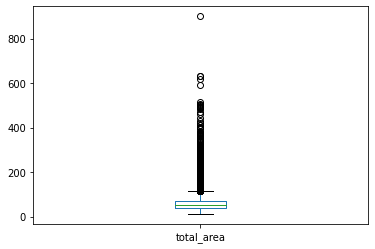

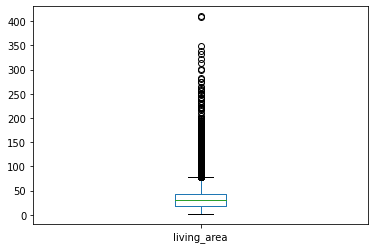

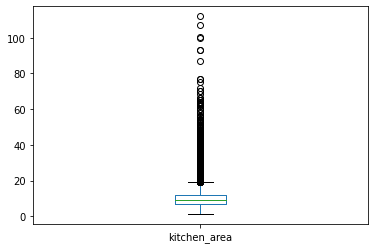

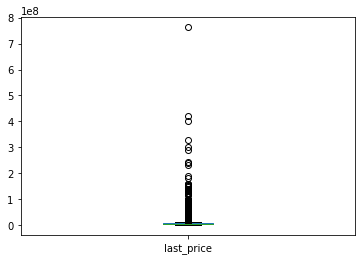

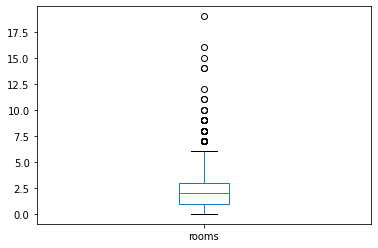

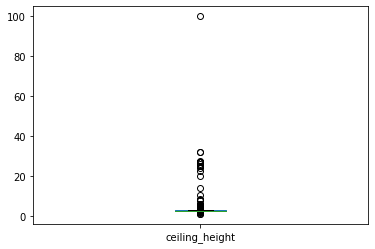

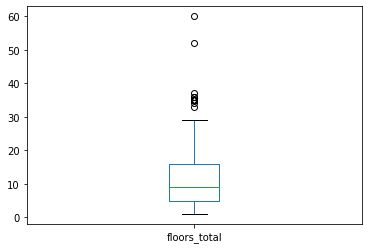

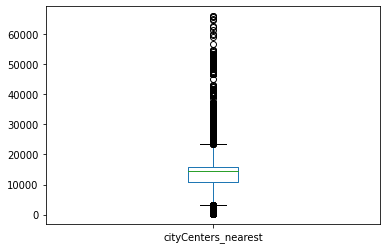

In [34]:

for col in research_cols:
    try:
        (
        good_data
        .plot(y=col, kind='box')
        )
    except:
        pass


Проанализировав возможные площади комнат в квартире, избавимся от значений, в которых средняя площадь комнаты больше 100м2

In [35]:
good_data = good_data[good_data['total_area'] / good_data['rooms'] < 100]

В столбцах *ceiling_height* (высота потолка в 32 метра) и *floors_total* (62 этажа в здании) встречаются аномалии.        

Обработаем их с помощью функций.

In [36]:
def height_cor(row):
    h = row['ceiling_height']
    if h >= 20:
         return h / 10
    else:
        return h  

In [37]:
good_data['ceiling_height'] = good_data.apply(height_cor, axis=1)

In [38]:
def floor_cor(row):
    h = row['floors_total']
    if h >= 50 and h % 10 == 0:
         return h / 10
    else:
        return h

In [39]:
good_data['floors_total'] = good_data.apply(floor_cor, axis=1)

### Посмотрим, сколько времени уходит на продажу квартиры и как этот параметр влияет на её цену

<AxesSubplot:>

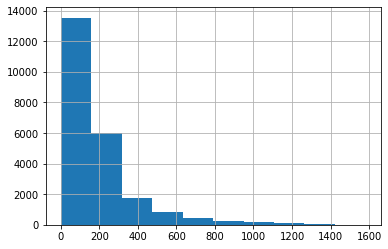

In [40]:
good_data['days_exposition'].hist()

In [41]:
good_data['days_exposition'].describe()

count    23225.000000
mean       182.697868
std        205.338109
min          1.000000
25%         45.000000
50%        125.000000
75%        220.000000
max       1580.000000
Name: days_exposition, dtype: float64

Среднее время продажи квартиры составляет 182 дня, а медианное значение и вовсе - 125 дней, однако стандартное отклонение от этого времени составляет немного-немало целых 205 дней.
Продажу квартиры можно назвать быстрой, если объявление не пролежало больше 45 дней, в то время как продажа становится долгой после 220-го дня. 

<AxesSubplot:xlabel='days_exposition', ylabel='last_price'>

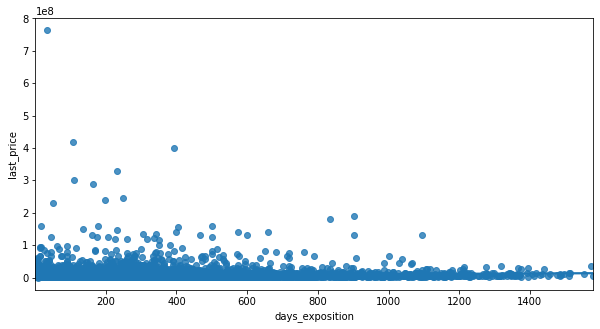

In [42]:
plt.figure(figsize=(10,5))
sns.regplot(data=good_data, x='days_exposition', y='last_price')

Можно заметить, что зависимость между количеством дней со времени начала продажи и ценой квартиры имеют зависимость, однако она крайне мала.

#### Определим факторы, которые больше всего влияют на конечную стоимость объекта

Поделим параметры, которые мы будим анализировать на числовые и категориальные

In [43]:
exp_num_cols = ['total_area', 'living_area', 'kitchen_area']
exp_cat_cols = ['rooms','floor_category', 'exposion_weekday', 'exposion_month', 'exposion_year']

In [44]:
for col in (exp_cat_cols):
    print(
        good_data.pivot_table(
        index=col,
        values='last_price',
        aggfunc=['mean', 'median', 'count']
                            )
         )

               mean       median      count
         last_price   last_price last_price
rooms                                      
1.0    3.817243e+06    3600000.0       7950
2.0    5.589219e+06    4768857.0       7854
3.0    8.160557e+06    6200000.0       5741
4.0    1.327739e+07    9000000.0       1164
5.0    2.361250e+07   14000000.0        324
6.0    3.211298e+07   18888500.0        102
7.0    5.147007e+07   24900000.0         59
8.0    5.022417e+07   23095000.0         12
9.0    3.415236e+07   23750000.0          8
10.0   2.616667e+07   23000000.0          3
11.0   2.525000e+07   25250000.0          2
12.0   4.200000e+08  420000000.0          1
14.0   2.682950e+07   26829500.0          2
15.0   6.500000e+07   65000000.0          1
16.0   2.850000e+07   28500000.0          1
19.0   3.225000e+07   32250000.0          1
                        mean     median      count
                  last_price last_price last_price
floor_category                                    
другой     

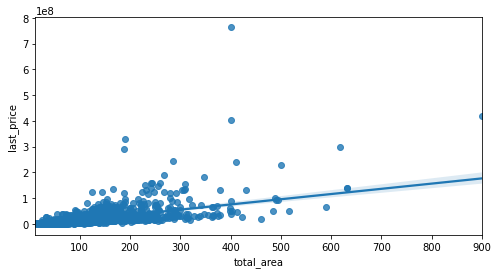

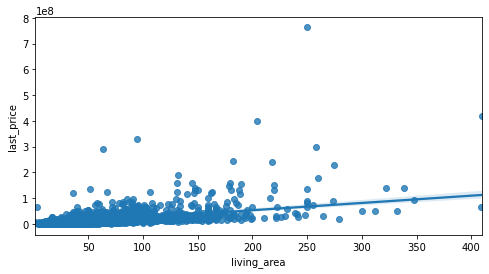

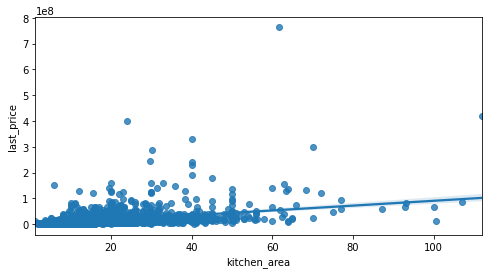

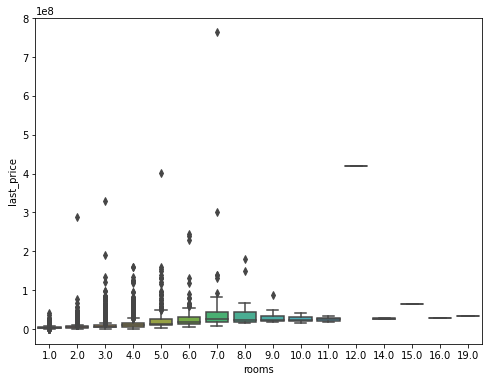

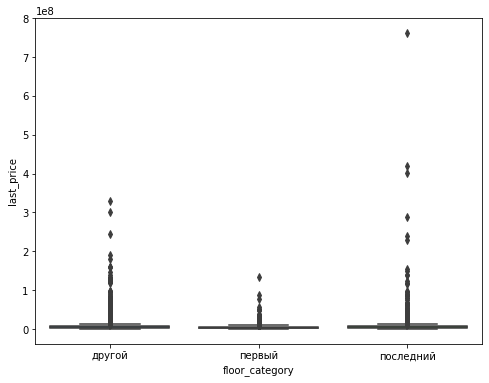

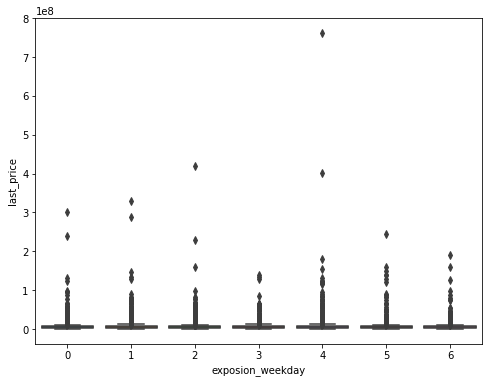

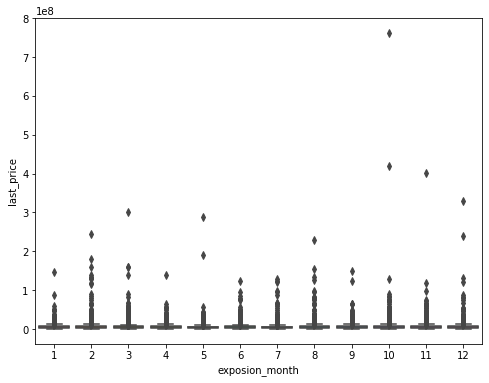

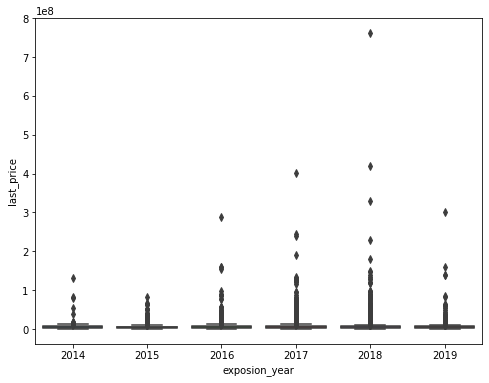

In [45]:
for col in exp_num_cols:
    plt.figure(figsize=(8,4))
    sns.regplot(data=good_data, x=col, y='last_price')
for col in exp_cat_cols:
    plt.figure(figsize=(8,6))
    sns.boxplot(data=good_data, x=col, y='last_price')

<AxesSubplot:>

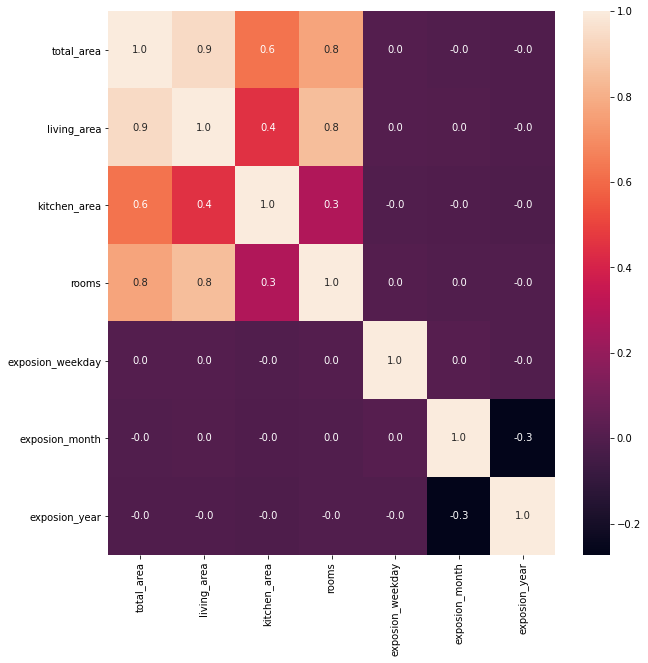

In [46]:
plt.figure(figsize=(10, 10))
sns.heatmap(good_data[exp_num_cols+exp_cat_cols].corr(), annot=True, fmt=".1f")

Таким образом, можно заметить, что:
- зависимость между площадью квартиры, жилой площадью, площадью кухни и ценой присутствует, но она далеко не линейна,
- количество комнат (например, пятикомнатные зачастую дороже остальных) влияет на конечную цену,
- цена квартиры, распологающейся на первом этаже немного ниже, чем на других, а значит этаж тоже влияет на итоговую сумму,
- конеечная цена квартиры не зависит от дня, месяца или года выпуска заявления

#### Найдём среднюю цену за квадратный метр в 10 населённых пунктах с самым большим и маленьким количеством объявлений

In [47]:
most_ad_df = good_data.pivot_table(index='locality_name', values='price_per_meter', aggfunc=['mean', 'count'])
most_ad_df.columns = ['mean_price', 'ads']
most_ad_df.sort_values('ads', ascending=False, inplace=True) 
most_ad_df.head(10)

,mean_price,ads
locality_name,,
санкт-петербург,99285.805880,15439
поселок мурино,99913.515298,543
поселок шушары,97599.651254,435
всеволожск,102568.823009,394
пушкин,101957.694212,364
колпино,96627.891485,330
поселок парголово,102353.700293,321
гатчина,99664.529741,303
поселок кудрово,105013.916079,293


Таким образом, средняя цена в 10 населённых пунктах с самым большим количеством заявлений является примерно равной. А это значет, что местоположение квартиры в большинстве случаев не играет важной роли в ценообразовании.

#### Посмотрим, как влияет на цену расстояние от центра города в Санкт-Петербурге

In [48]:
peter_table = (
        good_data[good_data['locality_name'] == 'санкт-петербург']
        .groupby('cityCenters_nearest_km')
        .agg({'last_price': 'mean', 'cityCenters_nearest_km': 'count'})
        .rename(columns={'last_price': 'mean_price'})
              )
peter_table

,mean_price,cityCenters_nearest_km
cityCenters_nearest_km,,
0.0,2.984788e+07,20
1.0,2.112780e+07,135
2.0,1.810409e+07,207
3.0,1.121041e+07,230
4.0,1.453621e+07,468
5.0,1.485401e+07,593
6.0,1.380874e+07,433
7.0,1.427610e+07,281
8.0,1.023335e+07,391


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55]),
 [Text(0, 0, '0.0'),
  Text(1, 0, '1.0'),
  Text(2, 0, '2.0'),
  Text(3, 0, '3.0'),
  Text(4, 0, '4.0'),
  Text(5, 0, '5.0'),
  Text(6, 0, '6.0'),
  Text(7, 0, '7.0'),
  Text(8, 0, '8.0'),
  Text(9, 0, '9.0'),
  Text(10, 0, '10.0'),
  Text(11, 0, '11.0'),
  Text(12, 0, '12.0'),
  Text(13, 0, '13.0'),
  Text(14, 0, '14.0'),
  Text(15, 0, '15.0'),
  Text(16, 0, '16.0'),
  Text(17, 0, '17.0'),
  Text(18, 0, '18.0'),
  Text(19, 0, '19.0'),
  Text(20, 0, '20.0'),
  Text(21, 0, '21.0'),
  Text(22, 0, '22.0'),
  Text(23, 0, '23.0'),
  Text(24, 0, '24.0'),
  Text(25, 0, '25.0'),
  Text(26, 0, '26.0'),
  Text(27, 0, '27.0'),
  Text(28, 0, '28.0'),
  Text(29, 0, '29.0'),
  Text(30, 0, '30.0'),
  Text(31, 0, '31.0'),
  Text(32, 0, '32.0'),
  T

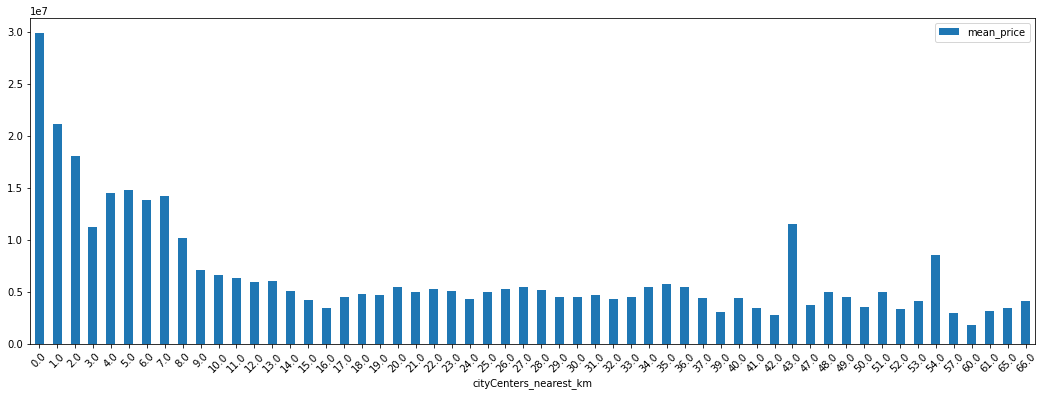

In [49]:
peter_table.plot(y='mean_price', kind='bar', figsize=(18, 6))
plt.xticks(rotation=45)

По графику видно, что расстояние от центра города играет большую роль в образовании итоговой цены квартиры в Санкт-Петербурге.
Так, квартиры, находящиеся в пределах восьми километров от центра значительно дороже других.
Однако присутствуют два исключения(на 43км и 54км). Это связано с тем, что объявлений с таким расстоянием от цента мало, а цена высокая, поэтому они и выбиваются из общего вывода.

## Общий вывод

В ходе предообработки данных

- столбцы *is_apartment*, *balcony*, *parks_nearest*, *ponds_nearest* были удалены из таблицы из-за недостатка данных
- в таблице были удалены строки, в которых были пропущены значения в столбцах *floors_total*, *locality_name*
- оставшиеся пропущенные значения были заменены на наиболее подходящие в зависимости от других данных
- изменены типы данных столбцов first_day_exposition, open_plan и studio,
- удалены неявные дубликаты в столбце *locality_name*
- были добавлены столбцы *price_per_meter*, *exposion_weekday*, *exposion_month*, *exposion_year*

В ходе работы с данными я сделал вывод, что на цену квартиры больше всего влияют:
- общая площадь,
- жилая площадь,
- площадь кухни,
- количество комнат,
- расположение квартиры относительно центра населённого пункта,
- количество дней, которое было размещено объявление.


Данное исследование может помочь в настройке автоматизированной системы с целью поиска аномалий и мошеннической деятельности.